# Assignment 3 by Pranit Santosh Hande (s3971628)


In [1]:
#Data Preprocessing
#importing required libraries
import collections
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading the data
ratings_data = 'ratings.dat'
movies_data = 'movies.dat'
users_data = 'users.dat'

ratings_df = pd.read_csv(ratings_data, sep="::", engine='python', names=["UserID", "MovieID", "Rating", "Timestamp"],encoding = 'latin-1')
movies_df = pd.read_csv(movies_data, sep='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='latin-1')
users_df = pd.read_csv(users_data, sep='::', engine='python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')

In [3]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
total_users = ratings_df['UserID'].nunique()
print(f"Total Users: {total_users} users")

Total Users: 6040 users


In [7]:
total_movies = ratings_df['MovieID'].nunique()
print(f"Total Movies: {total_movies} movies")

Total Movies: 3706 movies


In [8]:
#Maximum MovieId in the ratings_df 
max_movie_id = ratings_df.MovieID.max()

# Task 1: User-based Collaborative Filtering


In [9]:
#Spliting the data into train and test(80:20)
train_data, test_data = train_test_split(ratings_df, test_size=0.2)

# Training Dataset filled with zeroes 
train_ds = pd.DataFrame(np.zeros((total_users, max_movie_id)))

for row in train_data.itertuples():
    train_ds.at[row[1]-1, row[2]-1] = row[3]-1

# Testing Dataset filled with zeroes
test_ds = pd.DataFrame(np.zeros((total_users, max_movie_id)))

for row in test_data.itertuples():
    test_ds.at[row[1]-1, row[2]-1] = row[3]-1

In [10]:
# Calculating cosine similarity
cosine_s = cosine_similarity(train_ds.fillna(0))

#Dictinary to map Movie id's to titles
movie_names = dict(zip(movies_df['MovieID'], movies_df['Title']))

# Choosing a random user
active_user = 1

# Specifying the K values 
K_values = [5,10,15,20,25]
EPSILON = 1e-9
#Initialize list to store the results
data_list = []

for K in K_values:
    # Find the top-K most similar users as the current user, excluding itself
    knn = NearestNeighbors(n_neighbors=K, metric='cosine')
    knn.fit(cosine_s)
    similar_user_index = knn.kneighbors(cosine_s[active_user].reshape(1, -1), return_distance=False)[0][1:]

    t1_predictions = np.zeros(max_movie_id) #Array for predictions

    recommendations = []  #list to store movie recommendations

    for j in range(max_movie_id):
        #Calculating the mean rating of the active user 
        user_mean = np.sum(train_ds.values[active_user]) / (np.sum(np.clip(train_ds.values[active_user], 0, 1)) + EPSILON)
                
        # retriving ratings of similar user and their mean rating
        similar_users = train_ds.values[similar_user_index]
        sim_user_mean = np.sum(similar_users, axis=1) / (np.sum(np.clip(similar_users, 0, 1), axis=1) + EPSILON)

        if train_ds.iloc[active_user, j] != 0:
            t1_predictions[j] = train_ds.iloc[active_user, j] 
        else:
            #Calcualting predicted ratongs
            mask_rated_j = similar_users[:, j] > 0
            sim_r_sum_mean = cosine_s[active_user][similar_user_index[mask_rated_j]] * (similar_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])
            t1_predictions[j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(cosine_s[active_user][similar_user_index[mask_rated_j]]) + EPSILON)
            t1_predictions[j] = np.clip(t1_predictions[j], 0, 5)

            # Adding recommendations to list if the active user has not watched the movie
            if train_ds.iloc[active_user, j] == 0:
                recommendations.append((j, t1_predictions[j]))

    # Sorting recommendations by predicted ratings 
    recommendations.sort(key=lambda x: x[1], reverse=True)
    #Store the results in data list
    data_list.append([active_user, K, t1_predictions.tolist(), recommendations])  # Include recommendations
    
    #Displaying top 5 movie recommendations and the user's predicted rating 
    print(f'For user {active_user}, K={K}, Predicted Ratings: {t1_predictions}')
    print(f'Recommendations for K={K}:')
    for i, (movie_id, predicted_rating) in enumerate(recommendations[:5], start=1):
        movie_title = movie_names.get(movie_id, "Unknown Title")  # Retriving  the movie title from the dictionary
        print(f'{i}: "{movie_title}" - Predicted Rating: {predicted_rating:.2f}')
    print('-----\n')

For user 1, K=5, Predicted Ratings: [3.8966018  2.52644114 2.72727273 ... 2.72727273 2.72727273 2.72727273]
Recommendations for K=5:
1: "Vertigo (1958)" - Predicted Rating: 4.21
2: "Killer, The (Die xue shuang xiong) (1989)" - Predicted Rating: 4.21
3: "Virtuosity (1995)" - Predicted Rating: 4.08
4: "Clear and Present Danger (1994)" - Predicted Rating: 4.08
5: "When a Man Loves a Woman (1994)" - Predicted Rating: 4.08
-----

For user 1, K=10, Predicted Ratings: [3.2318088  2.52644114 1.45168218 ... 2.72727273 2.72727273 2.72727273]
Recommendations for K=10:
1: "Kicking and Screaming (1995)" - Predicted Rating: 4.25
2: "Unknown Title" - Predicted Rating: 4.25
3: "Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)" - Predicted Rating: 4.25
4: "Matewan (1987)" - Predicted Rating: 4.25
5: "Killer, The (Die xue shuang xiong) (1989)" - Predicted Rating: 4.21
-----

For user 1, K=15, Predicted Ratings: [3.17346059 2.31046956 2.05243151 ... 2.72727273 2.72727273 0.87495206]
Recommendations for K=15

In [11]:
#Calculating AP and NDCG
# Lists to store results for AP and NDCG for K
ap_knncf = []
ndcg_knncf = []

for K in K_values:
    # Calculate AP value for the recommendations
    ground_truth_ratings = [1 if train_ds.iloc[active_user, movie_id] > 0 else 0 for movie_id in range(max_movie_id)]
    ap_user = average_precision_score(ground_truth_ratings, t1_predictions)
    
    # Calculate NDCG value for the recommendations
    ndcg_user = ndcg_score([ground_truth_ratings], [t1_predictions], k=25)  # You can adjust 'k' as needed
    
    # Appending AP and NDCG values to the lists
    ap_knncf.append(ap_user)
    ndcg_knncf.append(ndcg_user)

# Calculate the average AP and NDCG for all K values
average_ap_KNNCF = sum(ap_knncf) / len(ap_knncf)
average_ndcg_KNNCF = sum(ndcg_knncf) / len(ndcg_knncf)

# Display the average
print(f"Average AP for KKNCF: {average_ap_KNNCF:.4f}")
print(f"Average NDCG for KNNCF: {average_ndcg_KNNCF:.4f}")

Average AP for KKNCF: 0.1825
Average NDCG for KNNCF: 0.0526


In [12]:
#Evaluation

#Actual ratings
orignal_ratings = test_ds.values

# Calculating the squared error for ratings
squared_error = np.square(t1_predictions - orignal_ratings)

# Calculate the squared error for rated ratings by applying the weight
squared_error *= np.square(np.clip(orignal_ratings, 0, 1))

# Calculate RMSE
RMSE = np.sqrt(np.sum(squared_error) / np.sum(np.clip(orignal_ratings, 0, 1)))

print("RMSE for User-based Collaborative Filtering: " + str(RMSE))

RMSE for User-based Collaborative Filtering: 1.01173747914736


# Task 2: Item-based Filtering

## Cosine Similarity

In [13]:
#Item Based CF (Cosine Similarity)
# Calculating cosine similarity for item-item
item_cosine = cosine_similarity(train_ds.T)

# Active movie id
chosen_movie_id = 4

# Define K value for K Nearest
K = 10
EPSILON = 1e-9

# Array to store the predicted ratings
t2_pred_cosine = np.zeros(total_users)

# Finding the top K movies that are similar to the selected movie
sim_item_index = np.argsort(item_cosine[chosen_movie_id])[-(K + 1):-1]
similar_item_similarity = item_cosine[chosen_movie_id][sim_item_index]

# Calculating average ratings for selected movie and similar items
selected_movie_ratings = train_ds.T.values[chosen_movie_id]
selected_movie_mean = np.sum(selected_movie_ratings) / (np.sum(np.clip(selected_movie_ratings, 0, 1)) + EPSILON)
similar_items = train_ds.T.values[sim_item_index]
similar_items_means = np.sum(similar_items, axis=1) / (np.sum(np.clip(similar_items, 0, 1), axis=1) + EPSILON)

# Iterating through the users to predict ratings for selected movie
for user_index in range(total_users):
    if train_ds.T.values[chosen_movie_id][user_index] == 0:
        weight_ratings_difference = similar_item_similarity * (similar_items[:, user_index] - similar_items_means)
        mask = np.clip(similar_items[:, user_index], 0, 1)
        weight_ratings_difference *= mask

        if np.sum(similar_item_similarity) == 0:
            t2_pred_cosine[user_index] = selected_movie_mean
        else:
            t2_pred_cosine[user_index] = selected_movie_mean + np.sum(weight_ratings_difference) / (np.sum(similar_item_similarity) + EPSILON)

        t2_pred_cosine[user_index] = np.clip(t2_pred_cosine[user_index], 0, 5)
        t2_pred_cosine[user_index] = np.round(t2_pred_cosine[user_index])
        
#Displaying predicted ratings of the users for the choosen movie
for user_index in range(total_users):
    predicted_rating = t2_pred_cosine[user_index]
    print(f"User {user_index}: Movie {chosen_movie_id}: Predicted Rating :{predicted_rating:.2f}")


User 0: Movie 4: Predicted Rating :2.00
User 1: Movie 4: Predicted Rating :2.00
User 2: Movie 4: Predicted Rating :2.00
User 3: Movie 4: Predicted Rating :2.00
User 4: Movie 4: Predicted Rating :2.00
User 5: Movie 4: Predicted Rating :2.00
User 6: Movie 4: Predicted Rating :2.00
User 7: Movie 4: Predicted Rating :2.00
User 8: Movie 4: Predicted Rating :2.00
User 9: Movie 4: Predicted Rating :2.00
User 10: Movie 4: Predicted Rating :2.00
User 11: Movie 4: Predicted Rating :2.00
User 12: Movie 4: Predicted Rating :2.00
User 13: Movie 4: Predicted Rating :2.00
User 14: Movie 4: Predicted Rating :2.00
User 15: Movie 4: Predicted Rating :2.00
User 16: Movie 4: Predicted Rating :2.00
User 17: Movie 4: Predicted Rating :2.00
User 18: Movie 4: Predicted Rating :2.00
User 19: Movie 4: Predicted Rating :2.00
User 20: Movie 4: Predicted Rating :2.00
User 21: Movie 4: Predicted Rating :2.00
User 22: Movie 4: Predicted Rating :2.00
User 23: Movie 4: Predicted Rating :2.00
User 24: Movie 4: Predicte

In [14]:
# Evaluation(Item Based CF using Cosine Similarity)

#Actual ratings
orignal_ratings = test_ds.T.values

#Squared error for ratings
squared_error = np.square(t2_pred_cosine - orignal_ratings)

#Applying weight by squaring error for the rated movies
weight = np.clip(orignal_ratings, 0, 1)
squared_error = squared_error * weight

#Calculating RMSE 
RMSE_cosine = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE for Item-based Collaborative Filtering using Cosine Similarity: " + str(RMSE_cosine));

RMSE for Item-based Collaborative Filtering using Cosine Similarity: 1.4431863969462515


## Jaccard Similarity

In [15]:
from sklearn.metrics import pairwise_distances
# Calculate item-item Jaccard similarity

# Convert Pandas DF to NumPy arrays
train_ds_np = train_ds.to_numpy()

#Using Jaccard similarity for item-item
item_jaccard_similarity = 1 - pairwise_distances(train_ds_np.T, metric='jaccard')

#The values of K, EPSILON and MovieID are the same as used in the cosine similarity
#chosen_movie_id = 4
#K = 10
#EPSILON = 1e-9

# Array to store the predicted ratings
t2_pred_jaccard = np.zeros(total_users)

# Finding top-K most similar items to the selected movie
sim_item_index = np.argsort(item_jaccard_similarity[chosen_movie_id])[-(K + 1):-1]
similar_item_similarity = item_jaccard_similarity[chosen_movie_id][sim_item_index]

# Calculate the average rating for the chosen movie and similar items
selected_movie_ratings = train_ds_np.T[chosen_movie_id]
selected_movie_mean = np.sum(selected_movie_ratings) / (np.sum(np.clip(selected_movie_ratings, 0, 1)) + EPSILON)
similar_items = train_ds_np.T[sim_item_index]
similar_items_means = np.sum(similar_items, axis=1) / (np.sum(np.clip(similar_items, 0, 1), axis=1) + EPSILON)

# Iterating through the users to predict their ratings for selected movie
for user_index in range(total_users):
    if train_ds_np.T[chosen_movie_id][user_index] == 0:
        weight_ratings_difference = similar_item_similarity * (similar_items[:, user_index] - similar_items_means)
        mask = np.clip(similar_items[:, user_index], 0, 1)
        weight_ratings_difference *= mask

        if np.sum(similar_item_similarity) == 0:
            t2_pred_jaccard[user_index] = selected_movie_mean
        else:
            t2_pred_jaccard[user_index] = selected_movie_mean + np.sum(weight_ratings_difference) / (np.sum(similar_item_similarity) + EPSILON)

        t2_pred_jaccard[user_index] = np.clip(t2_pred_jaccard[user_index], 0, 5)
        t2_pred_jaccard[user_index] = np.round(t2_pred_jaccard[user_index])

#Displaying predicted rating for the selcted movie for all users
for user_index in range(total_users):
    predicted_rating = t2_pred_jaccard[user_index]
    print(f"User {user_index}: Movie {chosen_movie_id}:Predicted Rating: {predicted_rating:.2f}")


User 0: Movie 4:Predicted Rating: 2.00
User 1: Movie 4:Predicted Rating: 2.00
User 2: Movie 4:Predicted Rating: 2.00
User 3: Movie 4:Predicted Rating: 2.00
User 4: Movie 4:Predicted Rating: 2.00
User 5: Movie 4:Predicted Rating: 2.00
User 6: Movie 4:Predicted Rating: 2.00
User 7: Movie 4:Predicted Rating: 2.00
User 8: Movie 4:Predicted Rating: 2.00
User 9: Movie 4:Predicted Rating: 3.00
User 10: Movie 4:Predicted Rating: 2.00
User 11: Movie 4:Predicted Rating: 2.00
User 12: Movie 4:Predicted Rating: 2.00
User 13: Movie 4:Predicted Rating: 2.00
User 14: Movie 4:Predicted Rating: 2.00
User 15: Movie 4:Predicted Rating: 2.00
User 16: Movie 4:Predicted Rating: 2.00
User 17: Movie 4:Predicted Rating: 2.00
User 18: Movie 4:Predicted Rating: 2.00
User 19: Movie 4:Predicted Rating: 2.00
User 20: Movie 4:Predicted Rating: 2.00
User 21: Movie 4:Predicted Rating: 2.00
User 22: Movie 4:Predicted Rating: 2.00
User 23: Movie 4:Predicted Rating: 2.00
User 24: Movie 4:Predicted Rating: 2.00
User 25: M

In [16]:
#Evaluation for Jaccard Similarity for item-item
orignal_ratings = test_ds.T.values

#Squared error for ratings
squared_error = np.square(t2_pred_jaccard - orignal_ratings)

#Applying weight by squaring error of rated movies
weight = np.clip(orignal_ratings, 0, 1)
squared_error = squared_error * weight

#RMSE calculation for Jaccard Similarity
RMSE_jaccard = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE for Item-based CF using Jaccard Similarity: " + str(RMSE_jaccard))

RMSE for Item-based CF using Jaccard Similarity: 1.4436061620760676


# Task 3: A Better Recommender System

## 3.1

In [17]:
#Creating a pivot table to format it one row per user and one column per movie
rating_pivot = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rating_pivot.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Denormalize the data and convert it from a dataframe to numpy array
x = rating_pivot.values
ratings_mean = np.mean(x, axis = 1)
ratings_demeaned = x - ratings_mean.reshape(-1, 1)

In [19]:
from scipy.sparse.linalg import svds
#svds is being used because it allows us to choose how many latent factors you want to use to approximate the rating matrix instead of truncating it in the future.
U, sigma, Vt = svds(ratings_demeaned, k = 50)
#Converting the sigma which is values to a diagonal matrix form as to get predictions we are going to use matrix mutilpication
sigma = np.diag(sigma)
user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratings_mean.reshape(-1, 1)

In [20]:
#Prediction matrix for all the users
pred = pd.DataFrame(user_predicted_ratings, columns = rating_pivot.columns)
pred.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [21]:
def recommend_movies(predictions, UserID, movies, original_ratings, n_recommendations):
    
    # Sorting the users predictions
    user_row = UserID - 1
    filtered_user_predictions = pred.iloc[user_row].sort_values(ascending=False) 
    
    #Merging the users data in Movie data
    user_info = original_ratings[original_ratings.UserID== (UserID)]
    user_movie = (user_info.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(UserID, user_movie.shape[0]))
    print ('Recommendations for {0} movies not rated by the user.'.format(n_recommendations))
    
    # Recommending the highest predicted rating movies that the user has not seen yet.
    rec = (movies_df[~movies_df['MovieID'].isin(user_movie['MovieID'])].
         merge(pd.DataFrame(filtered_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:n_recommendations, :-1]
                      )

    return user_movie, rec

In [22]:
already_rated_movies, predictions = recommend_movies(pred, 1310, movies_df, ratings_df, 5)
predictions

User 1310 has already rated 24 movies.
Recommendations for 5 movies not rated by the user.


,MovieID,Title,Genres
1618,1674,Witness (1985),Drama|Romance|Thriller
1880,1961,Rain Man (1988),Drama
1187,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1216,1242,Glory (1989),Action|Drama|War
1202,1225,Amadeus (1984),Drama


In [23]:
#Evaluation
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

#Reader library
reader = Reader()

# Using Dataset library to load ratings data
r_data = Dataset.load_from_df(ratings_df[['UserID', 'MovieID', 'Rating']], reader)

# Using SVD algorithm.
t3_svd = SVD()

#5-fold cross-validation using cross_validate
results = cross_validate(t3_svd, r_data, measures=['RMSE'], cv=5, verbose=True)

#RMSE results
for fold, rmse in enumerate(results['test_rmse']):
    print(f"Fold {fold + 1}: RMSE = {rmse:.2f}")

# Average RMSE 
t3_avg_rmse = results['test_rmse'].mean()
print(f"Average RMSE: {t3_avg_rmse:.2f}")

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8755  0.8727  0.8754  0.8734  0.8719  0.8738  0.0014  
Fit time          18.32   17.52   18.13   16.78   20.03   18.16   1.08    
Test time         4.17    3.38    3.38    3.27    3.86    3.61    0.35    
Fold 1: RMSE = 0.88
Fold 2: RMSE = 0.87
Fold 3: RMSE = 0.88
Fold 4: RMSE = 0.87
Fold 5: RMSE = 0.87
Average RMSE: 0.87


In [24]:
# Import the necessary libraries
from sklearn.metrics import average_precision_score, ndcg_score

UserID = 42

#Determine the users row id 
user_row_id = UserID - 1  

# Calculating the predicted ratings
actual_ratings = pred.iloc[user_row_id].values
relevant_threshold = 4 #relevant threshold

# Calculating the binary relevance (1 : relevant, 0 : not relevant)
binary_relevance = [1 if rating >= relevant_threshold else 0 for rating in actual_ratings]

# Calculate Average Precision (AP)
Option1RecSys_AP = average_precision_score(binary_relevance, actual_ratings)
print(f'AP: {Option1RecSys_AP}')

# Calculate NDCG
relevance_matrix = [[1] if rating >= relevant_threshold else [0] for rating in actual_ratings]
true_relevance = binary_relevance
Option1RecSys_NDCG = ndcg_score([true_relevance], [actual_ratings])
print(f'NDCG: {Option1RecSys_NDCG}')


AP: 0.9999999999999999
NDCG: 0.9999999999999998


## 3.2

In [25]:
# Calculation of average rating of each movie
avg_ratings = ratings_df.groupby('MovieID')['Rating'].mean().reset_index()
avg_ratings = avg_ratings.rename(columns={'Rating': 'Average_Rating'})

# Sorting in descending order
sorted_movie_ratings = avg_ratings.sort_values(by='Average_Rating', ascending=False)

# User-Movie ratings. Represent movie as a matrix
user_movie_matrix = pd.pivot_table(ratings_df, values='Rating', index='UserID', columns='MovieID').fillna(0).to_numpy()
binary_user_movie_matrix = (user_movie_matrix > 0).astype(int)

# Find users who rated more than 100 movies
user_count = binary_user_movie_matrix.sum(axis=1)
active_user = np.where(user_count > 100)[0]

# Selecting 5 random users
if len(active_user) >= 5:
    selected_users = np.random.choice(active_user, 5, replace=False)

    # Dictionary to map MovieID to movie titles
    movieTitle = dict(zip(movies_df['MovieID'], movies_df['Title']))

    for user_id in selected_users:
        # Recommending top 30 movies for each of the 5 user
        recommended_movies = sorted_movie_ratings.head(30)
        movie_ids = recommended_movies['MovieID']

        user_name = users_df[users_df['UserID'] == user_id]['UserID'].values[0]

        # Displaying the recommended movies for 5 users with the ratings
        print(f"\n Reccomendation of Top 30 Movies for User {user_id} (ID: {user_id}) based on Highest Average Ratings: \n")
        for movie_id in movie_ids:
            movie_title = movieTitle.get(movie_id, 'Unknown')
            average_rating = sorted_movie_ratings[sorted_movie_ratings['MovieID'] == movie_id]['Average_Rating'].values[0]
            print(f"Movie Title: {movie_title}, Average Rating: {average_rating:.2f}")

else:
    print("There are less users who have rated more than 100 movies")


 Reccomendation of Top 30 Movies for User 35 (ID: 35) based on Highest Average Ratings: 

Movie Title: Schlafes Bruder (Brother of Sleep) (1995), Average Rating: 5.00
Movie Title: Bittersweet Motel (2000), Average Rating: 5.00
Movie Title: Follow the Bitch (1998), Average Rating: 5.00
Movie Title: Song of Freedom (1936), Average Rating: 5.00
Movie Title: Gate of Heavenly Peace, The (1995), Average Rating: 5.00
Movie Title: Baby, The (1973), Average Rating: 5.00
Movie Title: One Little Indian (1973), Average Rating: 5.00
Movie Title: Smashing Time (1967), Average Rating: 5.00
Movie Title: Ulysses (Ulisse) (1954), Average Rating: 5.00
Movie Title: Lured (1947), Average Rating: 5.00
Movie Title: I Am Cuba (Soy Cuba/Ya Kuba) (1964), Average Rating: 4.80
Movie Title: Lamerica (1994), Average Rating: 4.75
Movie Title: Apple, The (Sib) (1998), Average Rating: 4.67
Movie Title: Sanjuro (1962), Average Rating: 4.61
Movie Title: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954

In [26]:

# List to store each result for a user
user_ap_scores = []
user_ndcgs_scores = []
user_rmses_scores = []

for user_id in selected_users:
    # Recommendations and AP and NDCG calculations
    recommendations = np.argsort(user_movie_matrix[user_id])[::-1]
    ground_truth_ratings = binary_user_movie_matrix[user_id]

    ap_user = average_precision_score(ground_truth_ratings, recommendations)
    ndcg_user = ndcg_score([ground_truth_ratings], [recommendations], k=30)

    # RMSE
    predicted_ratings = user_movie_matrix[user_id]
    rmse_user = mean_squared_error(ground_truth_ratings, predicted_ratings, squared=False)

    # adding the user results to the list
    user_ap_scores.append(ap_user)
    user_ndcgs_scores.append(ndcg_user)
    user_rmses_scores.append(rmse_user)

# Calculating the metrics
ap_MovieAvg = np.mean(user_ap_scores)
ndcg_MovieAvg = np.mean(user_ndcgs_scores)
RMSE_MovieAvg = np.mean(user_rmses_scores)

# Display the results for each user
user_results = pd.DataFrame({
    "UserID": selected_users, "AP": user_ap_scores,"NDCG": user_ndcgs_scores
})

# Overall metrics
overall_metrics = pd.DataFrame({
    "Evaluation Metrics": ["AP", "NDCG", "RMSE"],
    "Value": [ap_MovieAvg, ndcg_MovieAvg, RMSE_MovieAvg]
})
print(overall_metrics)


  Evaluation Metrics     Value
0                 AP  0.105316
1               NDCG  0.102826
2               RMSE  0.845258


## Average Precision across KKNCF, OPTION1RECSYS AND MOVIEAVG

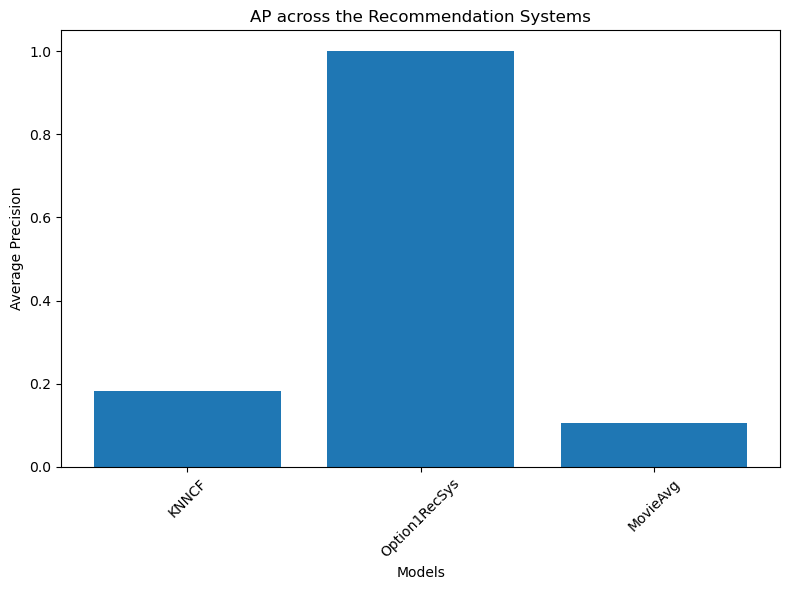

In [27]:
import matplotlib.pyplot as plt

# List of Recommendation systems names
RecSys_names = ["KNNCF", "Option1RecSys", "MovieAvg"]

# AP values 
ap_values = [average_ap_KNNCF ,Option1RecSys_AP ,ap_MovieAvg ]

# Create a bar plot for AP 
plt.figure(figsize=(8, 6))
plt.bar(RecSys_names, ap_values)
plt.xlabel('Models')
plt.ylabel('Average Precision')
plt.title('AP across the Recommendation Systems')
plt.xticks(rotation=45)  
plt.tight_layout()

# Show the plot
plt.show()


## Normalized Discounted cumulative gain(NDCG) across KKNCF, OPTION1RECSYS AND MOVIEAVG

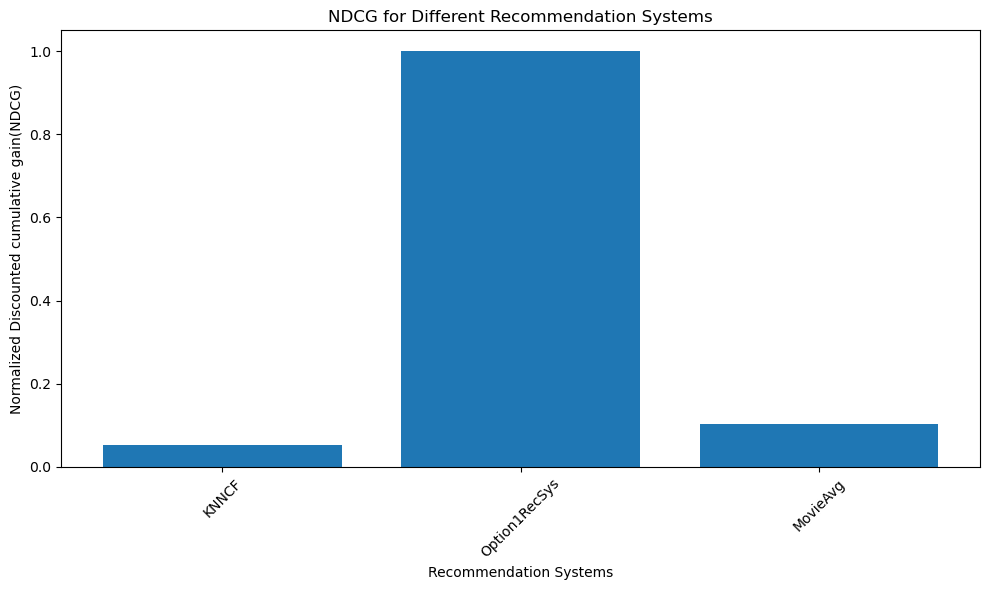

In [28]:
RecSys_names = ["KNNCF", "Option1RecSys", "MovieAvg"]

# NDCG values
ndcg_values = [average_ndcg_KNNCF ,Option1RecSys_NDCG ,ndcg_MovieAvg ]

# Create a bar plot for NDCG
plt.figure(figsize=(10, 6))
plt.bar(RecSys_names, ndcg_values)
plt.xlabel('Recommendation Systems')
plt.ylabel('Normalized Discounted cumulative gain(NDCG)')
plt.title('NDCG for Different Recommendation Systems')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


## Root Mean Squared Error (RMSE)across KKNCF, OPTION1RECSYS AND MOVIEAVG

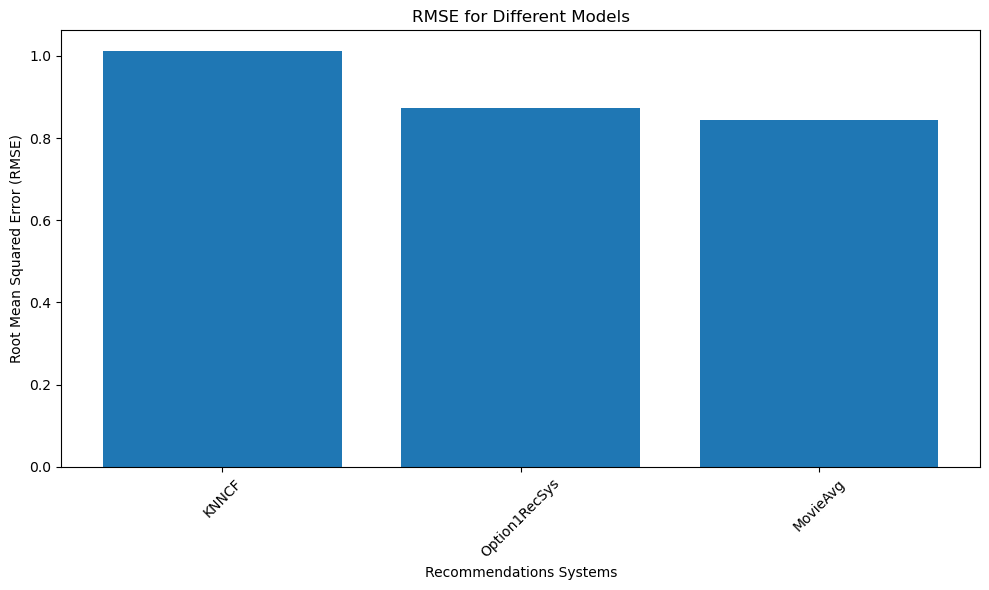

In [29]:
RecSys_names = ["KNNCF", "Option1RecSys", "MovieAvg"]

# RMSE values
rmse_values = [RMSE ,t3_avg_rmse ,RMSE_MovieAvg ]

# Create a bar plot for RMSE
plt.figure(figsize=(10, 6))
plt.bar(RecSys_names, rmse_values)
plt.xlabel('Recommendations Systems')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE for Different Models')
plt.xticks(rotation=45)  
plt.tight_layout()

#PLot
plt.show()
